## Linear Regression with PolyMath and Tensorflow
The simplest form of linear regression is learning the parameters for a one-dimensional line. We will generate an artificial dataset using Polymath. This example is a traslation to Polymath from the python version included in the book "Tensorflow for Deep learning" by Ramsundar, Bharath, O'Reilly.
<br/>
Using PMLinearCongruentialRandomGenerator we will obtain a collection of uniformely distributed numbers between 0 and 1. This collection will be a subset of x from the domain set, we will use it to calculate the image subset.<br/> 
PMNormalDistribution generates a normal distributed collection of numbers arround the median and a standard deviation (noiseScale). We use this noise to add it to the bias component in the linear function = wTrue * x + (bTrue + noise).

In [7]:
N:= 100.
wTrue := 5.0.
bTrue := 2.0.
noiseScale := 0.1.
rg := PMLinearCongruentialRandomGenerator new.
nd := PMNormalDistribution new:0 sigma:noiseScale.
"gets N random numbers as x"
x_np := (1 to:N) collect:[:n| rg next ]. 
"gets N elements from a normal distribution"
noise :=(1 to:N) collect:[:n| nd random ]. 
y_np := (1 to:N) collect:[:n| (wTrue * (x_np at:n)) + (bTrue + (noise at:n))].

toy := DataFrame fromColumns: (Array with:x_np with:y_np).

Roassal is able to represent scatter plots diagrams from any type of collection. 
As you can see, we can easily represent a scatter plot from a DataFrame. 

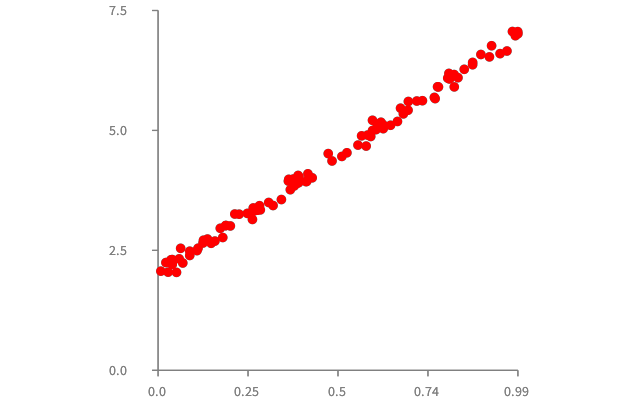

In [8]:
b := RTGrapher new.
b extent: 300 @ 300.
ds := RTData new.
ds dotShape size:8; color: Color red.
ds points: toy.
ds x:[:t| t at:1] .
ds y: [ :t |t at:2 ].
b add: ds.

self display openInJupyter:b

## Defining the Tensorflow graph
Tensorflow calculations are expresed as a graph of operations, inputs and variables.<br/>
We have to declare the inputs to the graph. Those inputs are called "placeholders", we define x and y placeholders to pass the collections of x and y inside a section called "placeholders". Because we are going to find the weight and bias for our linear function X*x + b, we declare weights and biases (W and b) as variables with a random initial value. Note that W and x is 2-dimensional so that we are able to calculate its matrix product otherwise tensorflow does not allows you to use the "MathMul" op. <br\>
Unluckly the C and C++ api for tensorflow does not support automatic differenciation yet, consequantly, pharo binding neither support it.<br/> 
We need to differentiate the loss function (squared error loss) and obtain the gradient  W and b, and apply them using #descent: on each variable<br/>
The idea of gradient descent is to find the minima of functions by repeatedly following the negative gradient.

In [17]:
learningRate := 0.0001 asTensor.
graph := TF_Graph create.
graph 
    fromBlock:[
        x := graph placeholder: 'x' type: TF_Tensor typeFloat.
        y := graph placeholder: 'y' type: TF_Tensor typeFloat]
    named: 'placeholders'.
    
graph 
    fromBlock:[
        W := graph 
                variable: 'weights' 
                initialValueFrom: (graph randomNormalShaped:{1. 1}).
        b := graph 
                variable: 'base'
                initialValueFrom: (graph randomNormalShaped:{1.})]
    named:'weights'.

y_pred :=graph 
      fromBlock:[
                (W * x) + b]
            named:'prediction'.
            
loss :=graph 
            fromBlock:[ 
            (y - y_pred) squared meanOn:#(1) asInt32Tensor]
            named:'loss'.

learn := graph 
            fromBlock:[
                m2 := graph const: -2.0 asFloatTensor.
                gradient :=  m2 @* ((y - y_pred) *\ x ).
                biasGradient :=  (m2 @*(y - y_pred) sumOn:#(1) asInt32Tensor).
                learnW:= W descent: gradient rate:learningRate .
                learnb := b descent: biasGradient rate:learningRate.]
            named:'optim'.



The algorithm will learn the W an b values by repeating the calculation of learnW and learnB 10000 times.


In [23]:
session :=TF_Session on: graph.
10000 timesRepeat:[
    session
            runInputs: {x input:0. y input:0 }
            values:{ {toy columnAt:1} asFloatTensor. {toy columnAt:2} asFloatTensor}
            outputs:{learnW output:0. learnb output:0}].

In [29]:
 result :=session
            runInputs: {x input:0. y input:0 }
            values:{ {toy columnAt:1} asFloatTensor. {toy columnAt:2} asFloatTensor}
            outputs:{ y_pred output:0.  }.

 
points :=  DataFrame fromColumns: (Array 
                                        with: (toy columnAt:1) 
                                        with: ((result at:1) asNumbers at:1)).

"points" are the predicted values by the algorithm, after the calculation of W and. b

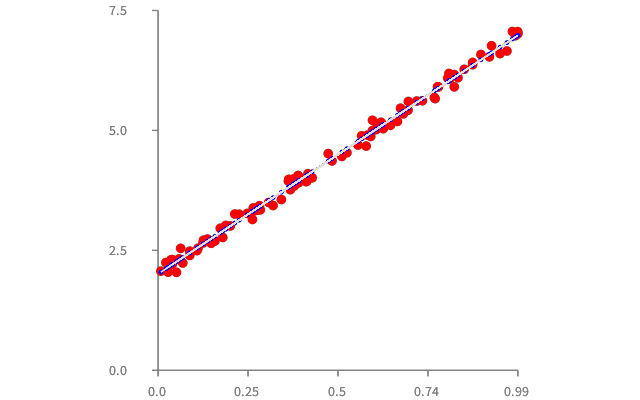

In [30]:
b := RTGrapher new.
b extent: 300 @ 300.


"data from the Toy dataframe"
ds := RTData new.
ds dotShape size:8; color: Color red.
ds points: toy.
ds x:[:t| t at:1] .
ds y: [ :t |t at:2 ].
b add: ds.
"data from the model"

ds := RTData new.
ds dotShape size:4; color: Color blue.
ds points: points.
ds x:[:t| t at:1] .
ds y: [ :t |t at:2 ].
ds connect.
b add: ds.

self display openInJupyter:b